# Hlavačka - Vančo,
# 50 - 50
# dataset 85

In [221]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from numpy import asarray
from numpy import percentile
from sklearn.preprocessing import LabelEncoder

# Načítanie a úprava dát z csv súborov.
V prvej fáze sme zanalyzovali, v ktorých stĺpcoch sa nachádzajú aké unikátne hodnoty. Tie, ktoré nám nič nehovorili ako napríklad otázniky sme nahradili hodnotami np.nan aby sa nám jednoduchšie nahrádzali, pretože k nim môžeme pristupovať ako ku chýbajúcim hodnotám. V prípade, keď stĺpec obsahoval viacero hodnôt, ktoré hovorili to isté, len boli inak napísené, tak sme ich nahradili jednotným označním(napríklad 'f', 'F', 'False' majú teraz jednotné označenie 'False'). 

V datasete sa objavovali aj duplikáty, ktoré sme zistili na základe mena, pričom jeden zo záznamov mal v niektorých atribútoch chýbajúce hodnoty a druhý mal validné dáta. Pomocou classy DropDuplicates sme tieto chýbajúce hodnoty nahradili, z čoho nám vznikli dva rovnaké záznamy, ktoré sme na konci dropli, pretože to boli duplikáty.

Osobám, ktorým chýbal vek sme ho vypočítali z dátumu narodenia a to nasledujúcim spôsobom. Najprv sme extrahovali rok narodenia z atribútu date_of_birth. Následne sme vytvorili pre tieto hodnoty samostatný column s názvom year_of_birth. Tým pádom sme stĺpec date_of_birth mohli dropnúť a pomocou atribútu year_of_birth vypočítať aktuálny vek osoby.

Adresu sme rozdelili na stĺpce street, city a zip_code. Vzhľadom na to, že v stĺpci zip_code nie sú chýbajúce hodnoty, tak sme mohli dropnúť stĺpce street a city. Zip_code nemal jednotný formát, tak sme ho upravili tým spôsobom, že sme  z neho nechali iba čísla.

In [175]:
# This class is used for personal and other dataset
class MySpritClass(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        for column_name in X:
            if X[column_name].dtypes == 'object':
                X[column_name] = X[column_name].str.strip()
        return X

# This class is used for other dataset    
class MyAdjustClass(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X['marital-status'] = X['marital-status'].replace('??', np.nan)
        X['occupation'] = X['occupation'].replace('?', np.nan)
        X['pregnant'] = X['pregnant'].replace(['f', 'F', 'FALSE'], 'False')
        X['pregnant'] = X['pregnant'].replace(['t', 'T', 'TRUE'], 'True')
        X['relationship'] = X['relationship'].replace('Not_in_family', 'Not-in-family')
        X['relationship'] = X['relationship'].replace('Own_child', 'Own-child')
        X['relationship'] = X['relationship'].replace('Other_relative', 'Other-relative')
        X['native-country'] = X['native-country'].replace('?', np.nan)
        X['workclass'] = X['workclass'].replace('?', np.nan)
        
        return X

# This class is used for other dataset
class SeparateAndDeleteMedicalInfo(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.separate_and_delete_medical_info(X)
        return X
    
    def separate_and_delete_medical_info(self, dataframe):
        df2 = pd.DataFrame() 
        # Iterate through every row and take values from medical_info column
        for _,column_data in dataframe['medical_info'].iteritems(): 
            if isinstance(column_data, str): # If value isn't nan
                column_data = column_data[1:-1] # Delect curly brackets from start and end of string
                column_data_split = column_data.split(',') # Split string by comma

                row = {} 
                for name_value in column_data_split: # Iterate through split string
                    name_value_split = name_value.split(':') # Split into name of column and value of column
                    # Store value into dictionary with name of the column as a key
                    row[name_value_split[0][1:-1]] = [np.float(name_value_split[1][1:-1])] # Get rid of '' by [1:-1]

                row_data_frame = pd.DataFrame(row) # Convert dictionary into DataFrame
                df2 = df2.append(row_data_frame, ignore_index=True) # Append row_data_frame into df2
            else: # Value is nan, append nan row into df2
                df2 = df2.append(pd.Series(np.nan), ignore_index=True)

        df2 = df2.drop(columns=[0]) # Drop last column

        # Add values from df2 to main df
        for column_name in df2.columns:
            dataframe[column_name] = df2[column_name]

        del dataframe['medical_info'] # medical info is already divided into another columns, so we can erase it

        return dataframe

# This class is used for personal dataset
class SeparateAndDeleteAddress(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.separate_and_delete_address(X)
        return X
    
    def separate_and_delete_address(self, dataframe):
        df_addresses = dataframe['address'].replace('\r', ',', regex=True)
        df_addresses = df_addresses.replace('\n', ' ', regex=True)
        df_addresses = df_addresses.str.split(',')

        cities = []
        streets = []
        zip_codes = []

        for address in df_addresses:
            if len(address) < 3: # these records have cities in address
                streets.append(address[0])
                cities.append(None)
                zip_codes.append(address[1])
            else: # these records don't have cities in address
                streets.append(address[0])
                cities.append(address[1])
                zip_codes.append(address[2])

        dataframe['street'] = streets
        dataframe['city'] = cities
        dataframe['zip_code'] = zip_codes

        dataframe = dataframe.drop('address', axis=1)

        return dataframe
    
# This class is used for joined dataset    
class DropDuplicates(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.drop_duplicates(X)
        return X
    
    def drop_duplicates(self, data_frame):
        df1 = data_frame[data_frame.duplicated('name', keep=False)].sort_values('name')

        for i in range(0,len(df1.index),2):
            for (column_name1, column_data1), (_, column_data2) in zip(df1.iloc[i].iteritems(), df1.iloc[i + 1].iteritems()):
                if pd.isnull(column_data1):
                    data_frame.loc[df1.iloc[i]['name'] == data_frame['name'], column_name1] = column_data2
                else:
                    data_frame.loc[df1.iloc[i]['name'] == data_frame['name'], column_name1] = column_data1

        data_frame = data_frame.drop_duplicates()

        return data_frame
    
# This class is used for joined dataset    
class ExtractYear(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.extract_year(X)
        return X
    
    def extract_year(self, data_frame):
        years = []
        for cell in data_frame['date_of_birth']:
            if re.match('^[0-9]{2}\-[0-9]{2}\-[0-9]{2}$', cell):
                year = cell[:2]
                years.append(int('19' + year))
            elif re.match('[0-9]{4}', cell):
                years.append(int(re.findall('[0-9]{4}', cell)[0]))
            elif re.match('^[0-9]{2}\/[0-9]{2}\/[0-9]{4}$', cell):
                years.append(int(cell[-4:]))

        data_frame['year_of_birth'] = years

        return data_frame.drop(columns=['date_of_birth'])
    
# This class is used for joined dataset    
class CalculateAgeFromYear(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.calculate_age_from_year(X)
        return X
    
    def calculate_age_from_year(self, data_frame):
        new_age = []
        for (age, data1), (year, data2) in zip(data_frame['age'].iteritems(), data_frame['year_of_birth'].iteritems()):
            if pd.isnull(data1):
                new_age.append(2020 - data2)
            else:
                new_age.append(data1)

        data_frame['age'] = new_age

        return data_frame
    
# This class is used for joined dataset    
class GetNumberFromZipCodeDropCityStreet(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.get_number_from_zip_code(X)
        X = X.drop('city', axis=1)
        X = X.drop('street', axis=1)
        return X
    
    def get_number_from_zip_code(self, dataframe):
        zip_numbers = []
        for zip_code in dataframe['zip_code']:
            zip_numbers.append(int(re.findall('[0-9]{4}', zip_code)[0]))

        dataframe['zip_code'] = zip_numbers
        
        return dataframe    

## Úprava other datasetu
Už pri načítaní sme dropli prvý stĺpec, ktorý nič nehovoril, pretože bol Unnamed. Následne sme aplikovali sprit na atribúty, ktoré boli typu object, aby sa s nimi lepšie pracovalo a mohli sme ich upraviť na jednotný formát. Potom sme zmenili označenie atribútov, ktoré mali tú istú hodnotu, len vyjadrenú iným formátom. Ako poslednú úpravu pre tento dataset sme rozdelili object medical info na stĺpce mean_oxygen, std_oxygen, kurtosis_oxygen a skewness_oxygen.

In [176]:
# other_train
df_other = pd.read_csv('./other_train.csv', sep=',', index_col=0) # First column is Unnamed

other_pipe = Pipeline(steps = [
    ('Sprit', MySpritClass()),
    ('Adjust', MyAdjustClass()),
    ('Separate and delete medical info', SeparateAndDeleteMedicalInfo())
])

df_other = other_pipe.transform(df_other)

## Úprava personal datasetu
V tomto prípade sme tiež mohli dropnúť už pri načítaní stĺpec Unnamed. Tiež sme vykonali sprit na atribúty typu object a zložený atribút address sme rozdelili na atribúty street, city a zip_code.

In [177]:
# personal_train
df_personal = pd.read_csv("./personal_train.csv", index_col=0, sep=',') # First column was Unnamend

personal_pipe = Pipeline(steps = [
    ('Sprit', MySpritClass()),
    ('Separate and delete address', SeparateAndDeleteAddress())
])

df_personal = personal_pipe.transform(df_personal)

## Join datasetov
Po samostatnej úprave datasetov sme ich joinli podľa mena a dropli stĺpec address, ktorý bol z datasetu other, pretože sme ho mali rozložený na atribúty street, city a zip_code.
Takisto sme dropli aj capital gain a capital loss, pretože tieto stĺpce obsahovali priveľké množstvo 0 a nedá sa určiť, či je to nameraná hodnota, alebo neexistujúce dáta.

In [178]:
df_joined = df_other.merge(df_personal, on='name', how='left') # join other train and personal train on name
del df_joined['capital-gain']
del df_joined['capital-loss']
del df_joined['address'] # we can also erase disgusting address column, because we have it in detail from personal train

## Úprava joinutého datasetu
Na joinutom datasete bolo potrebné vyriešiť problém s duplikátmi, výpočet aktuálneho veku pre osoby, ktoré ho v zázname nemali uvedený a úprava zip_code na jednotný formát. Tieto procesy sú bližšie opísane na začiatku tejto kapitoly.

In [179]:
joined_pipe = Pipeline(steps = [
    ('Drop duplicates', DropDuplicates()),
    ('Extract year', ExtractYear()),
    ('Calculate age from year and drop date_of_birth', CalculateAgeFromYear()),
    ('Get numbers from zip_code and drop city and street', GetNumberFromZipCodeDropCityStreet())
])

df_joined = joined_pipe.transform(df_joined)

<ipython-input-175-069f6547d23e>:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['year_of_birth'] = years


Síce tu vyhodí warning, ale spraví to, čo má.

In [180]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3982
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3933 non-null   object 
 1   race              3933 non-null   object 
 2   marital-status    3540 non-null   object 
 3   occupation        3710 non-null   object 
 4   pregnant          3933 non-null   object 
 5   education-num     3932 non-null   float64
 6   relationship      3933 non-null   object 
 7   skewness_glucose  3932 non-null   float64
 8   mean_glucose      3933 non-null   float64
 9   kurtosis_glucose  3933 non-null   float64
 10  education         3933 non-null   object 
 11  fnlwgt            3931 non-null   float64
 12  class             3933 non-null   float64
 13  std_glucose       3931 non-null   float64
 14  income            3933 non-null   object 
 15  native-country    3874 non-null   object 
 16  hours-per-week    3932 non-null   float64


Výpočtom veku pre záznamy, ktoré ho nemali sme si ušetrili robotu pri náhradzaní chýbajúcich hodnôt.

In [181]:
df_joined.describe()

,education-num,skewness_glucose,mean_glucose,kurtosis_glucose,fnlwgt,class,std_glucose,hours-per-week,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen,age,zip_code,year_of_birth
count,3932.000000,3932.000000,3933.000000,3933.000000,3.931000e+03,3933.000000,3931.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3933.000000,3933.000000,3933.000000
mean,10.073245,4.219811,63.696776,0.951283,1.911450e+05,0.255276,45.172534,40.535097,18.479727,31.152712,7.414067,91.315050,51.936435,5026.287567,1966.993389
std,2.674246,9.679145,3358.120098,1.610970,1.073383e+05,0.436072,7.608810,12.301212,34.793133,22.269962,4.812653,108.560937,11.820871,2871.409016,11.820308
min,1.000000,-1.755332,-18973.437500,-1.641515,1.882700e+04,0.000000,25.695250,1.000000,0.213211,7.370432,-2.597872,-1.976976,-1.000000,52.000000,1906.000000
25%,9.000000,-0.120081,83.859375,0.072144,1.179345e+05,0.000000,40.163947,40.000000,2.064799,15.039457,3.636259,12.863954,45.000000,2498.000000,1959.000000
50%,10.000000,0.374657,110.539062,0.310784,1.795120e+05,0.000000,45.869299,40.000000,3.234532,20.564154,7.783017,68.505049,52.000000,5018.000000,1967.000000
75%,13.000000,2.083826,125.359375,0.776762,2.416740e+05,1.000000,50.361097,45.000000,12.635452,43.229414,10.263412,127.017151,60.000000,7527.000000,1974.000000
max,16.000000,68.101622,15887.500000,8.069522,1.366120e+06,1.000000,91.206475,99.000000,217.371238,110.642211,34.539844,1191.000837,113.000000,9994.000000,2020.000000


In [182]:
df_joined.head()

,name,race,marital-status,occupation,pregnant,education-num,relationship,skewness_glucose,mean_glucose,kurtosis_glucose,...,hours-per-week,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen,age,sex,zip_code,year_of_birth
0,David Hayes,Black,NaN,Prof-specialty,False,5.0,Not-in-family,-0.197692,141.359375,-0.252430,...,40.0,Private,4.042642,19.456469,6.410765,49.813954,45.0,Female,1952,1974
1,Stanley Benny,White,Married-civ-spouse,Exec-managerial,False,13.0,Husband,16.019670,53.968750,3.149333,...,40.0,Private,9.294314,35.958174,4.424007,19.868969,42.0,Male,2201,1977
2,Domingo Labriola,Asian-Pac-Islander,Married-civ-spouse,Farming-fishing,False,3.0,Husband,21.803837,2257.812500,4.650770,...,40.0,Private,138.787625,79.152788,-0.445270,-0.909086,46.0,Male,4180,1973
3,Ronnie Moore,White,Never-married,Other-service,False,10.0,Not-in-family,-0.112191,110.046875,0.441957,...,40.0,Private,3.100334,17.819373,8.434320,85.665564,53.0,Male,3273,1966
4,Victor Mcjunkin,White,NaN,Adm-clerical,False,10.0,Not-in-family,-0.309642,137.960938,-0.048518,...,40.0,Private,4.203177,23.949006,6.531796,45.866688,52.0,Female,7107,1967


## Zhrnutie
Po tejto fáze majú hodnoty jednotlivých atribútov jednotný formát, čo bolo našim cieľom. Pri ich úprave sme využili Pipeline z sklearn, taktiež sme vytvorili vlastné classy a funkcie na úpravu dáta, takže riešenie je znovu použitelné aj na testovacie dáta.

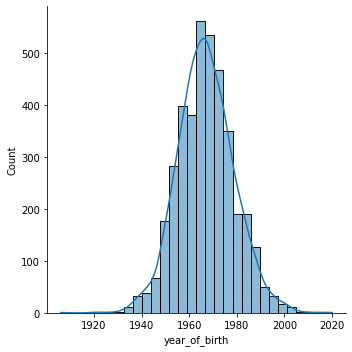

In [183]:
sns.displot(df_joined['year_of_birth'], kde=True, bins=30) # Distribution of age values, Positive kurtosis and normal skewness

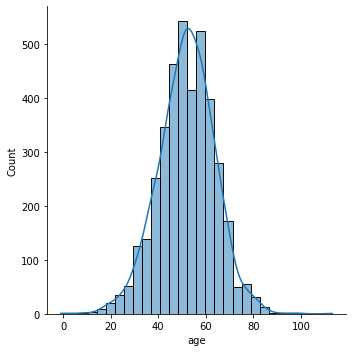

In [184]:
sns.displot(df_joined['age'], kde=True, bins=30) # Distribution of age values, Positive kurtosis and normal skewness

Nový atribút year_of_birth a atribút age s doplnenými chýbajúcimi hodnotami maju dobré normálové rozdelenie, s čím sa bude neskôr dobre pracovať.

# Riešenie chýbajúcich hodnôt

In [185]:
class FillNaNsWithMean(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        nan_map = X.isnull().any(axis=1)
        X[nan_map]

        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        for column_name in X:
            if X[column_name].dtypes != 'object':
                X[column_name] = imp.fit_transform(X[[column_name]])
                X[nan_map]

        return X
    
class FillNaNsWithMostFrequent(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        nan_map = X.isnull().any(axis=1)
        X[nan_map]

        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        for column_name in X:
            if X[column_name].dtypes == 'object':
                X[column_name] = imp.fit_transform(X[[column_name]])
                X[nan_map]

        return X

## Nahradenie chýbajúcich hodnôt v číselných atribútoch pomocou stratégie priemeru

In [186]:
filling_nans_pipe = Pipeline(steps = [
    ('Filling NaNs with mean strategy', FillNaNsWithMean())
])

df_joined = filling_nans_pipe.transform(df_joined)

In [187]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3982
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3933 non-null   object 
 1   race              3933 non-null   object 
 2   marital-status    3540 non-null   object 
 3   occupation        3710 non-null   object 
 4   pregnant          3933 non-null   object 
 5   education-num     3933 non-null   float64
 6   relationship      3933 non-null   object 
 7   skewness_glucose  3933 non-null   float64
 8   mean_glucose      3933 non-null   float64
 9   kurtosis_glucose  3933 non-null   float64
 10  education         3933 non-null   object 
 11  fnlwgt            3933 non-null   float64
 12  class             3933 non-null   float64
 13  std_glucose       3933 non-null   float64
 14  income            3933 non-null   object 
 15  native-country    3874 non-null   object 
 16  hours-per-week    3933 non-null   float64


### Zhrnutie doplňania chýbajúcich hodnôt pre číselné atribúty podľa stratégie priemeru
Doplnenie chýbajúcej hodnoty/hodnôt nezmenilo distribúciou, pretože sa väčšinou dopĺňala jedna, max 2 hodnoty. Tým pádom nebolo možné, aby takáto malá úprava zmenila distribúciu na takomto množstve záznamov, preto sme jednotlivé distribúcie ani nevykreslovi. Taktiež nie je potrebné vyskúšať ďalšie stratégie riešenia chýbajúcich hodnôt, pretože by  to bol minimálny rozdiel(ak vôbec nejaký) oproti tejto. 

## Riešenie chýbajúcich hodnôt v nečíselných atribútoch

In [188]:
most_frequent_pipe = Pipeline(steps = [
    ('Filling NaNs with most frequent strategy', FillNaNsWithMostFrequent())
])

df_joined = most_frequent_pipe.transform(df_joined)

In [189]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3982
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3933 non-null   object 
 1   race              3933 non-null   object 
 2   marital-status    3933 non-null   object 
 3   occupation        3933 non-null   object 
 4   pregnant          3933 non-null   object 
 5   education-num     3933 non-null   float64
 6   relationship      3933 non-null   object 
 7   skewness_glucose  3933 non-null   float64
 8   mean_glucose      3933 non-null   float64
 9   kurtosis_glucose  3933 non-null   float64
 10  education         3933 non-null   object 
 11  fnlwgt            3933 non-null   float64
 12  class             3933 non-null   float64
 13  std_glucose       3933 non-null   float64
 14  income            3933 non-null   object 
 15  native-country    3933 non-null   object 
 16  hours-per-week    3933 non-null   float64


### Zhrnutie doplňania chýbajúcich hodnôt pre nečíselné atribúty podľa stratégie most frequent
Po vykonaní tohto kroku dataset neobsahuje chýbajúceho hodnoty a je pripravený na riešenie vychýlených hodnôt a náslendú transformáciu

# Riešenie vychýlených hodnôt

Už z grafov z prvej fázy odovzdania bolo očividné, že niektoré hodnoty sa dosť líšia od priemeru. Domnievame sa, že niektoré hodnoty boli namerané v rôznych jednotkách, a preto sme sa rozhodli, že ich zjednodušíme.

In [190]:
df_joined['mean_glucose'].loc[df_joined['mean_glucose'] > 1000] /= 1000
df_joined['mean_glucose'].loc[df_joined['mean_glucose'] < -1000] /= 1000
df_joined['skewness_glucose'].loc[df_joined['skewness_glucose'] > 10] /= 10
df_joined['mean_oxygen'].loc[df_joined['mean_oxygen'] > 50] /= 10

c:\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

Neplatí to avšak pre všetky, a preto je nutné identifikovať a vysporiadať sa s outliermi. Medicínske dáta (oxygen, glucose) sú dosť odlišné od personálnych (age, education-num...) 

Použili sme metódy Interquartile Range Method na identifikáciu outlierov, pre každú skupinu s iným k-faktorom. Pre medicínske dáta sa usvedčila dobre hodnota k = 2. Takto nie je outlierov príliš veľa, ani príliš málo. Pre personálne hodnoty je nastavili k = 1.6, okrem 'hours-per-week', kde je k = 3. Tento údaj inak vydzahoval veľmi veľa outlierov.

Po identifikovaní outlierov pre každý stĺpec dataframu sa zistí ich počet. Ak ich je menej ako 50, rozhodli sme sa tieto záznamy dropnúť. Ak ich je viac, považujeme to za veľkú stratu dát a preto radšej ich hodnotu nastavíme na takú, ktorá je ešte hranične akceptovateľná ako nie outlier. 

Pre 'class' (hodnoty 0, 1) a 'zipcode', sme sa, pochopiteľne, rozhodli outlierov nehľadať. 

Pre jednoduchosť zmeníme pozíciu medicínskych dát tak, aby boli vedľa seba.

In [191]:
df_joined = df_joined[['name', 'race', 'marital-status', 'occupation', 'pregnant',
       'education-num', 'relationship', 'skewness_glucose', 'mean_glucose',
       'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'std_oxygen', 
       'kurtosis_oxygen', 'skewness_oxygen', 'fnlwgt', 'education', 'class',
       'income', 'native-country', 'hours-per-week', 'workclass',
       'age', 'sex', 'zip_code', 'year_of_birth']]

In [192]:
# medical data
class IdentifyAndReplaceMedicalOutliers(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.identify(X)
        return X
    
    def identify(self, dataframe):
        medical = ['skewness_oxygen', 'kurtosis_oxygen', 'std_oxygen', 'mean_oxygen',
                   'skewness_glucose', 'kurtosis_glucose', 'std_glucose', 'mean_glucose', 'fnlwgt']
        for col in dataframe.columns:
            if col not in medical:
                continue
                
            data = dataframe[col]
            # calculate interquartile range
            q25, q75 = percentile(data, 25), percentile(data, 75)
            iqr = q75 - q25

            # calculate the outlier cutoff
            cut_off = iqr * 2
            lower, upper = q25 - cut_off, q75 + cut_off
            
            # if there are few outliers, drop them
            if sum(dataframe[col] < lower) + sum(dataframe[col] > upper) < 50:
                for i in dataframe.index:
                    if ((dataframe.loc[i][col] < lower) or (dataframe.loc[i][col] > upper)):
                        dataframe = dataframe.drop([i])
            # otherwise make their value to more okey-ish
            else:
                dataframe[col] = dataframe[col].apply(lambda x: lower if x < lower else x)
                dataframe[col] = dataframe[col].apply(lambda x: upper if x > upper else x)
        return dataframe
    
    
# other data
class IdentifyAndReplaceOtherOutliers(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.identify(X)
        return X
    
    def identify(self, dataframe):
        other = ['age', 'hours-per-week', 'year_of_birth', 'education-num']
        for col in dataframe.columns:
            if col not in other:
                continue
                
            data = dataframe[col]
            # calculate interquartile range
            q25, q75 = percentile(data, 25), percentile(data, 75)
            iqr = q75 - q25
    
            # calculate the outlier cutoff
            k = 1.6
            if col == 'hours-per-week':
                k = 3
            cut_off = iqr * k
            lower, upper = q25 - cut_off, q75 + cut_off
            
#             outliers = [x for x in data if x < lower or x > upper] 
#             print(col)
#             print('Identified outliers: %d' % len(outliers))
            
            # if there are few outliers, drop them
            if sum(dataframe[col] < lower) + sum(dataframe[col] > upper) < 50:
                for i in dataframe.index:
                    if ((dataframe.loc[i][col] < lower) or (dataframe.loc[i][col] > upper)):
                        dataframe = dataframe.drop([i])
            # otherwise make their value to more okey-ish
            else:
                dataframe[col] = dataframe[col].apply(lambda x: lower if x < lower else x)
                dataframe[col] = dataframe[col].apply(lambda x: upper if x > upper else x)
        return dataframe

In [193]:
filling_nans_pipe = Pipeline(steps = [
    ('Identify medical outliers', IdentifyAndReplaceMedicalOutliers()),
    ('Identify other outliers', IdentifyAndReplaceOtherOutliers())
])

df_joined = filling_nans_pipe.transform(df_joined)

# Transformácia atribútu/ov pomocou Power transform (logaritmus, štandardizácia)

Transformácie riešime najmä pre medicínske dáta, pretože obsahujú číslené hodnoty v širokom intervale. Po vyriešení outlierov si zmeriame skewness jednotlivých stĺpcov dataframu. 

Ak je väčšia ako 2, vykonáme najprv logaritmickú transformáciu. Niektoré hodnoty sú menšie ako 0, musíme teda k celému tomuto stĺpcu pripočítať aspoň minimum zo stĺpca, aby sme získali kladnú hodnotu a mohli vôbec logaritmovať. 

Ak je hodnota skewness menšia ako 2, vykoná sa rovno štandardizácia. Tá sa vykoná vždy, aj keď je skewness väčšia ako 2, no v tom prípade je pre ňou ešte vyššie spomínaná logaritmická transformácia. Pomocou štandardizácie docielime, aby sa naše dáta pohybovali v okolí 0, no závislosti medzi nimi sa zachovali. 

In [194]:
# medical
class Transformation(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.makeNormal(X)
        return X
    
    def makeNormal(self, dataframe):
        medical = ['skewness_oxygen', 'kurtosis_oxygen', 'std_oxygen', 'mean_oxygen',
                   'skewness_glucose', 'kurtosis_glucose', 'std_glucose', 'mean_glucose', 'fnlwgt']
        for col in dataframe.columns:
            if col not in medical:
                continue
            # if the scewness is higher than 2, firstly, we do logaritmic transformation 
            if stats.skew(dataframe[col]) > 2:
                dataframe[col] = np.log(dataframe[col] + dataframe[col].min() + 0.5) # zbavíme sa záporných čísel
            
            # then, we scale the data
            
            # define standard scaler
            scaler = StandardScaler()

            # transform data
            scaled = scaler.fit_transform(np.array(dataframe[col]).reshape((len(dataframe[col]), 1)))
            dataframe[col] = scaled
            
        return dataframe

In [195]:
filling_nans_pipe = Pipeline(steps = [
    ('Transform into more normal distribution', Transformation())
])

df_joined = filling_nans_pipe.transform(df_joined)

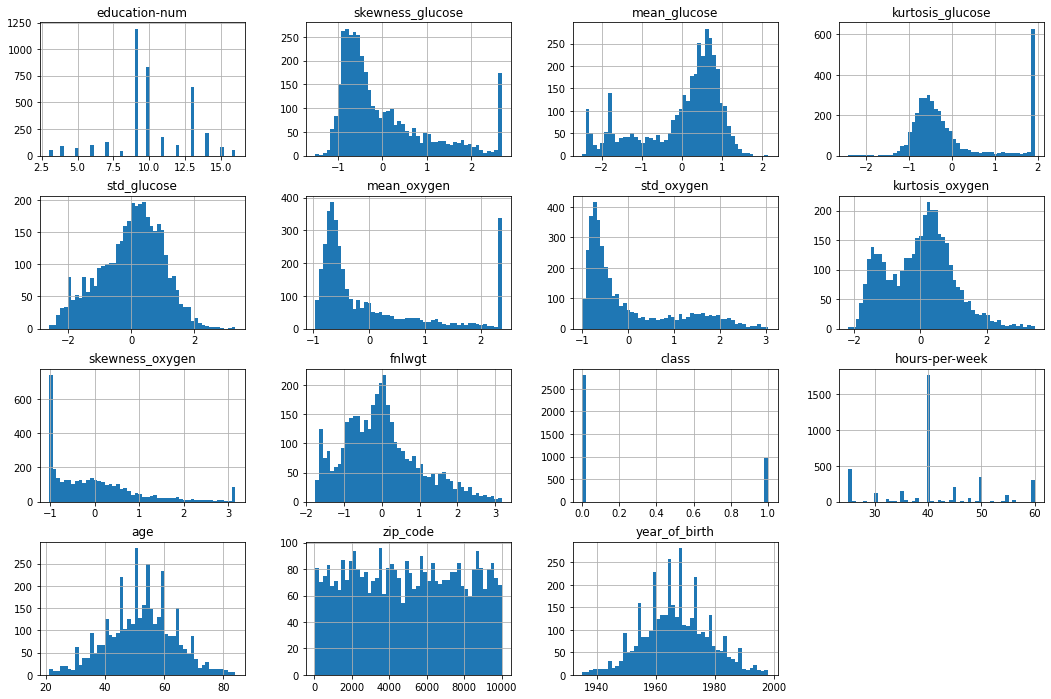

In [196]:
_ = df_joined.hist(figsize=(18, 12), bins=50)

# Transformácia kategorických atribútov na numerické

Keďže sa táto úprava skladá iba z jedného kroku, tak nám prišlo zbytočné vytvárať pipeline a použili sme vlastnú funkciu, ktorá identifikuje všetky kategorické atribúty v datasete a následne ich hodnoty transformuje na numerické.

In [197]:
def transform_categoric_to_numeric(dataframe):
    copy_dataframe = dataframe.copy()
    label_encoder = LabelEncoder()
    
    for column_name in copy_dataframe:
        if copy_dataframe[column_name].dtypes == 'object':
            copy_dataframe[column_name] = label_encoder.fit_transform(copy_dataframe[column_name])
            
    return copy_dataframe

df_for_ML = transform_categoric_to_numeric(df_joined)

In [198]:
df_for_ML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3778 entries, 0 to 3982
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3778 non-null   int32  
 1   race              3778 non-null   int32  
 2   marital-status    3778 non-null   int32  
 3   occupation        3778 non-null   int32  
 4   pregnant          3778 non-null   int32  
 5   education-num     3778 non-null   float64
 6   relationship      3778 non-null   int32  
 7   skewness_glucose  3778 non-null   float64
 8   mean_glucose      3778 non-null   float64
 9   kurtosis_glucose  3778 non-null   float64
 10  std_glucose       3778 non-null   float64
 11  mean_oxygen       3778 non-null   float64
 12  std_oxygen        3778 non-null   float64
 13  kurtosis_oxygen   3778 non-null   float64
 14  skewness_oxygen   3778 non-null   float64
 15  fnlwgt            3778 non-null   float64
 16  education         3778 non-null   int32  


In [199]:
df_for_ML.head()

,name,race,marital-status,occupation,pregnant,education-num,relationship,skewness_glucose,mean_glucose,kurtosis_glucose,...,education,class,income,native-country,hours-per-week,workclass,age,sex,zip_code,year_of_birth
0,730,2,2,8,0,5.0,1,-0.776186,1.141905,-1.076295,...,5,0.0,0,34,40.0,2,45.0,0,1952.0,1974.0
1,3305,4,2,2,0,13.0,0,0.426649,-0.838290,1.927365,...,8,1.0,1,34,40.0,2,42.0,1,2201.0,1977.0
2,833,1,2,3,0,3.0,0,0.813244,-2.010014,1.927365,...,3,1.0,0,25,40.0,2,46.0,1,4180.0,1973.0
3,3123,4,4,6,0,10.0,1,-0.719040,0.432391,-0.220197,...,13,0.0,0,34,40.0,2,53.0,1,3273.0,1966.0
4,3570,4,2,0,0,10.0,1,-0.851010,1.064899,-0.824895,...,13,0.0,0,34,40.0,2,52.0,0,7107.0,1967.0


Pomocou LabelEncodera sa nám podarilo transformovať všetky kategorické atribúty na číselné. Tieto úpravy sme nerobili na datasete df_joined, pretože ako posledný bod je dokumentácia zmien oproti prieskumnej analýze, čo by sme chceli porovnávať s atribútmi, ktoré majú rovnaký formát hodnôt ako mali tie v prieskumnej analýze, aby to pre čitateľa nebolo mätúce.

<AxesSubplot:>

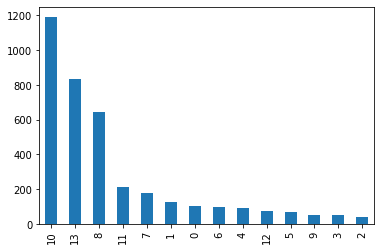

In [200]:
df_for_ML['education'].value_counts().plot(kind='bar')

<AxesSubplot:>

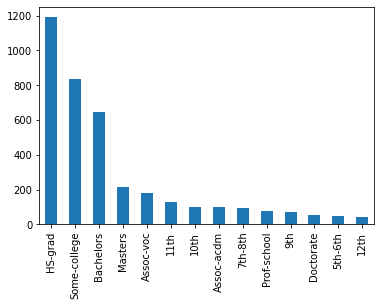

In [201]:
df_joined['education'].value_counts().plot(kind='bar')

Tieto dva histogramy majú slúžiť len na kontrolu, či sa hodnoty atribútov správne transformovali.

# Opätovná realizácia podstatných častí prieskumnej analýzy
Očakáva sa že dokumentujete zmeny distribúcie hodnôt po realizácii predspracovania.

Následne dokumentujete LEN zmeny v prieskumnej analýze.

In [202]:
df_analyse_joined = df_other.merge(df_personal, on='name', how='left') # join other train and personal train on name
del df_analyse_joined['address'] # we can also erase disgusting address column, because we have it in detail from personal train

### Dataset z prieskumnej analýzy

In [203]:
df_analyse_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3983 non-null   object 
 1   race              3971 non-null   object 
 2   marital-status    3570 non-null   object 
 3   occupation        3744 non-null   object 
 4   pregnant          3967 non-null   object 
 5   education-num     3971 non-null   float64
 6   relationship      3972 non-null   object 
 7   skewness_glucose  3968 non-null   float64
 8   mean_glucose      3974 non-null   float64
 9   capital-gain      3964 non-null   float64
 10  kurtosis_glucose  3970 non-null   float64
 11  education         3969 non-null   object 
 12  fnlwgt            3965 non-null   float64
 13  class             3972 non-null   float64
 14  std_glucose       3966 non-null   float64
 15  income            3971 non-null   object 
 16  native-country    3909 non-null   object 


Dataset pred tým ako sme aplikovali predspracovanie obsahoval 3983 záznamov, pričom niektoré znich mali chýbajúce hodnoty celkom veľkého počtu ako napríklad age alebo marital-status.

### Dataset po dokončení predspracovania

In [204]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3778 entries, 0 to 3982
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3778 non-null   object 
 1   race              3778 non-null   object 
 2   marital-status    3778 non-null   object 
 3   occupation        3778 non-null   object 
 4   pregnant          3778 non-null   object 
 5   education-num     3778 non-null   float64
 6   relationship      3778 non-null   object 
 7   skewness_glucose  3778 non-null   float64
 8   mean_glucose      3778 non-null   float64
 9   kurtosis_glucose  3778 non-null   float64
 10  std_glucose       3778 non-null   float64
 11  mean_oxygen       3778 non-null   float64
 12  std_oxygen        3778 non-null   float64
 13  kurtosis_oxygen   3778 non-null   float64
 14  skewness_oxygen   3778 non-null   float64
 15  fnlwgt            3778 non-null   float64
 16  education         3778 non-null   object 


Dataset po aplikovaní predspracovania obsahuje 3778 záznamov, pričom žiadny z nich neobsahuje chýbajúce hodnoty. Počet záznamov sa zredukoval pri riešení outlierov, z dôvodu vytvorenia lepšej distribúcie. 

Atribúty, ktoré sme identifikovali ako nepotrené sme dropli, takže dataset, ktorý zjavne využijeme pre ML obsahuje 25 atribútov namiesto 29.

Hodnoty atribútov majú jednotný formát a všetky sú transformované na numerické v datasete df_for_ML. Dataset df_joined sme využili v tomto bode iba z dôvodu lepšej ilustrácie zmien, ktoré sme dosiahli pomocou predspracovania.

In [205]:
df_joined.head()

,name,race,marital-status,occupation,pregnant,education-num,relationship,skewness_glucose,mean_glucose,kurtosis_glucose,...,education,class,income,native-country,hours-per-week,workclass,age,sex,zip_code,year_of_birth
0,David Hayes,Black,Married-civ-spouse,Prof-specialty,False,5.0,Not-in-family,-0.776186,1.141905,-1.076295,...,9th,0.0,<=50K,United-States,40.0,Private,45.0,Female,1952.0,1974.0
1,Stanley Benny,White,Married-civ-spouse,Exec-managerial,False,13.0,Husband,0.426649,-0.838290,1.927365,...,Bachelors,1.0,>50K,United-States,40.0,Private,42.0,Male,2201.0,1977.0
2,Domingo Labriola,Asian-Pac-Islander,Married-civ-spouse,Farming-fishing,False,3.0,Husband,0.813244,-2.010014,1.927365,...,5th-6th,1.0,<=50K,Philippines,40.0,Private,46.0,Male,4180.0,1973.0
3,Ronnie Moore,White,Never-married,Other-service,False,10.0,Not-in-family,-0.719040,0.432391,-0.220197,...,Some-college,0.0,<=50K,United-States,40.0,Private,53.0,Male,3273.0,1966.0
4,Victor Mcjunkin,White,Married-civ-spouse,Adm-clerical,False,10.0,Not-in-family,-0.851010,1.064899,-0.824895,...,Some-college,0.0,<=50K,United-States,40.0,Private,52.0,Female,7107.0,1967.0


### Dataset z prieskumnej analýzy

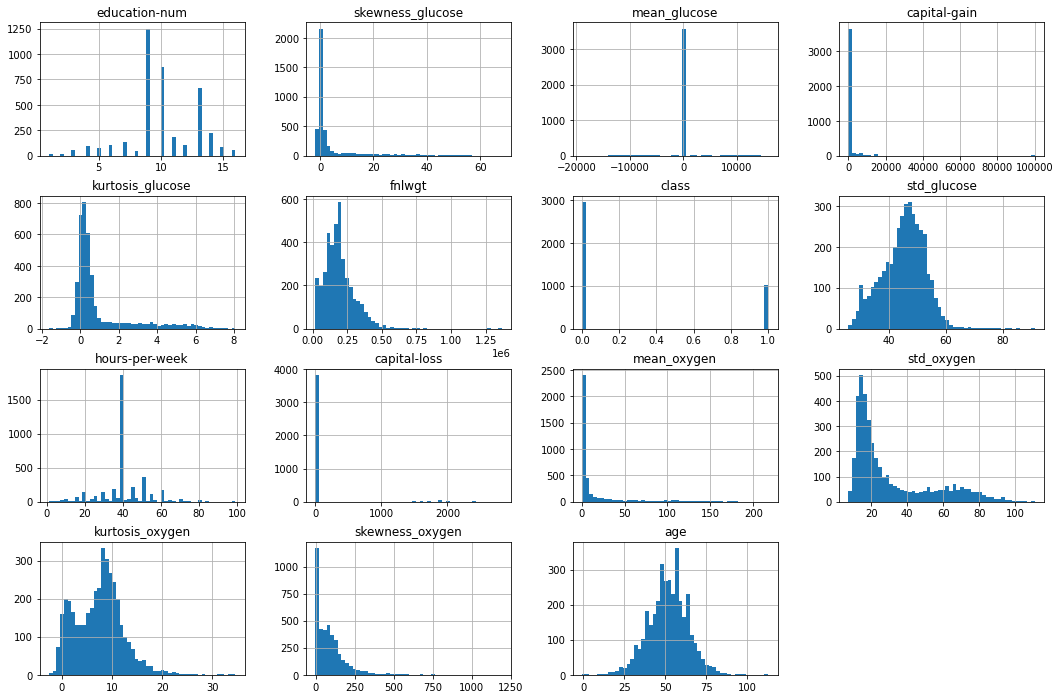

In [206]:
_ = df_analyse_joined.hist(figsize=(18, 12), bins=50)

### Dataset po dokončení predspracovania

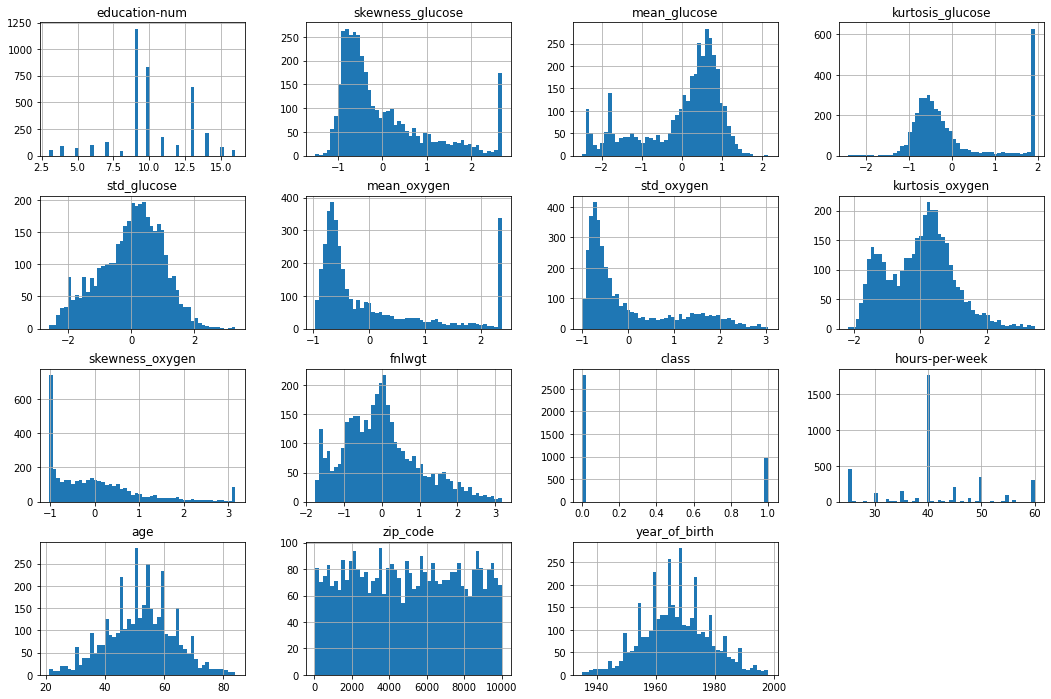

In [207]:
_ = df_joined.hist(figsize=(18, 12), bins=50)

Aby sme dosiahli transformácie zobrazené na grafe vyššie, museli sme vyhodiť outlierov, ktoré sa extrémne odlišovali od zvyšných hodnôt v atribúte. Následne sme na celý atribút implikovali transformáciu pomocou logaritmu a scalovania. Tým sme docielili, že transformované hodnoty sa pohybujú v okolí 0 a zachovali si svoj tvar.

### Dataset z prieskumnej analýzy

<AxesSubplot:xlabel='education-num', ylabel='income'>

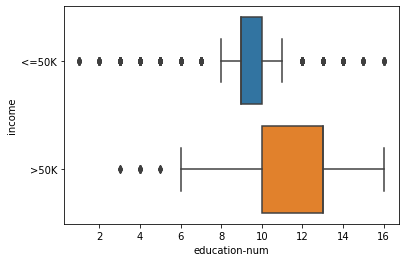

In [208]:
sns.boxplot(x='education-num', y='income', data=df_analyse_joined)

### Dataset po dokončení predspracovania

<AxesSubplot:xlabel='education-num', ylabel='income'>

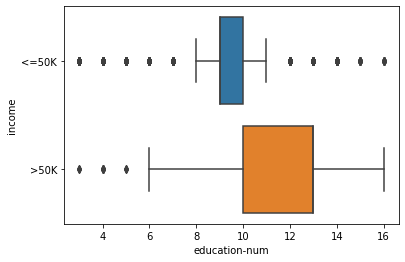

In [209]:
sns.boxplot(x='education-num', y='income', data=df_joined)

V atribúte educiaton-num sme podľa našej metódy identifikovali veľmi malý počet outlierov, tým pádom sa graf datasetu po dokončení predspracovania moc nelíši od grafu v prieskumnej analýze.

### Dataset z prieskumnej analýzy

<AxesSubplot:xlabel='hours-per-week', ylabel='relationship'>

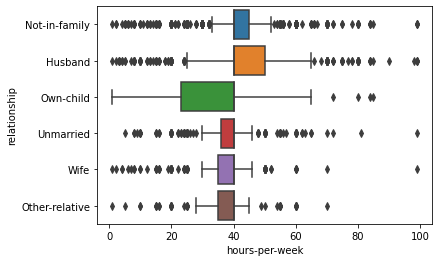

In [210]:
sns.boxplot(x='hours-per-week', y='relationship', data=df_analyse_joined)

### Dataset po dokončení predspracovania

<AxesSubplot:xlabel='hours-per-week', ylabel='relationship'>

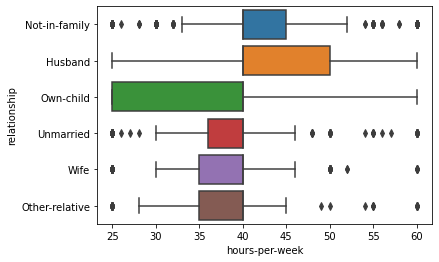

In [211]:
sns.boxplot(x='hours-per-week', y='relationship', data=df_joined)

Pre atribút hours-per-week naša metóda identifikovala veľmi veľa outlierov a preto sme museli zmeniť k-faktor. Ako je možné vidieť podaril sa nám dosť dobrý výsledok.

### Dataset z prieskumnej analýzy

<AxesSubplot:xlabel='hours-per-week', ylabel='occupation'>

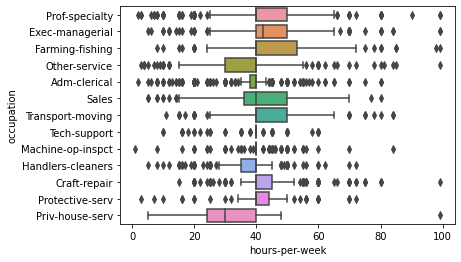

In [212]:
sns.boxplot(x='hours-per-week', y='occupation', data=df_analyse_joined)

### Dataset po dokončení predspracovania

<AxesSubplot:xlabel='hours-per-week', ylabel='occupation'>

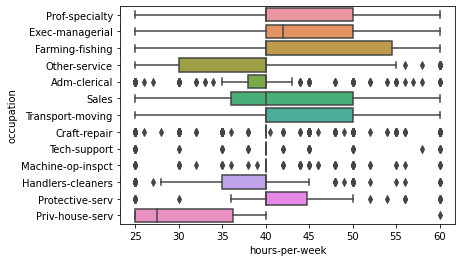

In [213]:
sns.boxplot(x='hours-per-week', y='occupation', data=df_joined)

Pre atribút hours-per-week naša metóda identifikovala veľmi veľa outlierov a preto sme museli zmeniť k-faktor. Ako je možné vidieť podaril sa nám dosť dobrý výsledok.

### Dataset z prieskumnej analýzy

<AxesSubplot:xlabel='hours-per-week', ylabel='sex'>

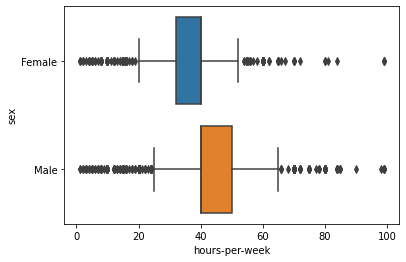

In [214]:
sns.boxplot(x='hours-per-week', y='sex', data=df_analyse_joined)

### Dataset po dokončení predspracovania

<AxesSubplot:xlabel='hours-per-week', ylabel='sex'>

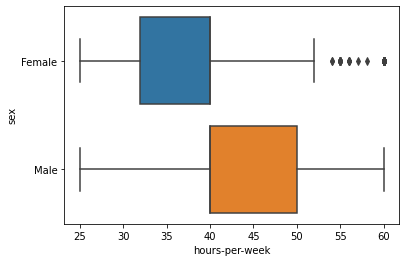

In [215]:
sns.boxplot(x='hours-per-week', y='sex', data=df_joined)

Pre atribút hours-per-week naša metóda identifikovala veľmi veľa outlierov a preto sme museli zmeniť k-faktor. Ako je možné vidieť podaril sa nám dosť dobrý výsledok.

### Dataset po dokončení predspracovania

year_of_birth je nový atribút, ktorý sme si vytvorili z date_of_birth, ktorý mal nejednotný formát a vďaka nemu sme boli schopný vypočítať chýbajúce hodnoty pre vek. Ako je možné vidieť, tak sa nám to podarilo a tieto dva atribúty naozaj korelujú.

<AxesSubplot:xlabel='year_of_birth', ylabel='age'>

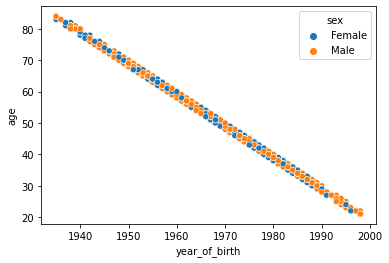

In [216]:
sns.scatterplot(x='year_of_birth', y='age', data=df_joined, hue='sex')

### Dataset z prieskumnej analýzy

<AxesSubplot:xlabel='kurtosis_oxygen', ylabel='std_oxygen'>

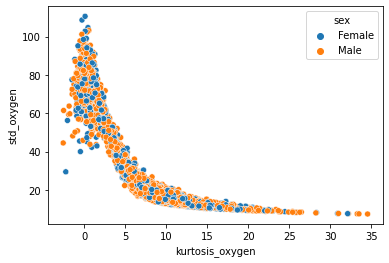

In [217]:
sns.scatterplot(x='kurtosis_oxygen', y='std_oxygen', data=df_analyse_joined, hue='sex')

### Dataset po dokončení predspracovania

<AxesSubplot:xlabel='kurtosis_oxygen', ylabel='std_oxygen'>

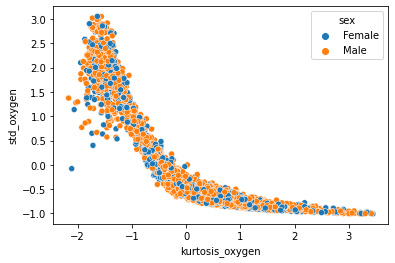

In [218]:
sns.scatterplot(x='kurtosis_oxygen', y='std_oxygen', data=df_joined, hue='sex')

Ako je možné vidieť aj po dokončení fázy predspracovania sa nám zachovali značné časti korelácie.

### Dataset z prieskumnej analýzy

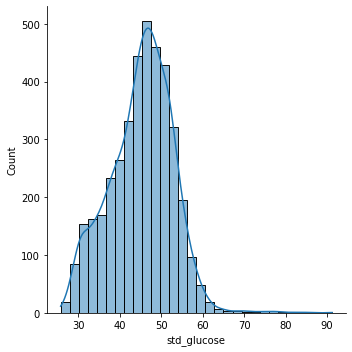

In [219]:
sns.displot(df_analyse_joined['std_glucose'], kde=True, bins=30)

### Dataset po dokončení predspracovania

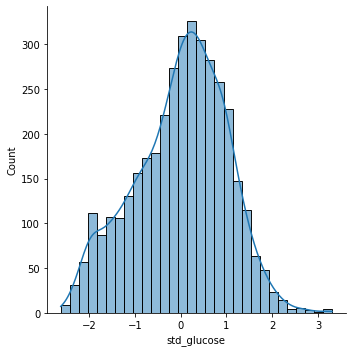

In [220]:
sns.displot(df_joined['std_glucose'], kde=True, bins=30)

Ako je vidieť z grafu po dokončení predspracovania atribút std_glucose sa o dosť viacej podobá na klasické normálové rozdelenie.

# Zhrnutie
## Úprava dát načítaných z csv súboru
Väčšinu problémov s datasetom sme identifikovali už vo fáze prieskumnej analýzy, avšak v tejto časti sme si všimli, že atribút date_of_birth nemá jednotný formát hodnôt, preto sme z neho extrahovali vek a vytvorili z neho atribút year_of_birth, vďaka ktorému sme dokázali vypočítať chýbajúce hodnoty v atribúte age. Podľa atribútu name sa nám podarilo identifikovať duplikáty, ktoré sme vyhodili.

## Nahradenie chýbajúcich hodnôt
Po aplikovaní tohto kroku dataset obsahoval veľmi malé množstvo chýbajúcich hodnôt pre numerické atribúty. Nechceli sme ich vyhadzovať, tak sme aplikovali stratégiu priemeru. Skúšanie ďalších stratégií nám prišlo zbytočné, pretože doplnenie jednej alebo dvoch chýbajúcich hodnôt na takom množstve dát nijak nezmenilo distribúciu. Chýbajúce hodnoty v kategorických atribútoch sme riešili stratégiou most_frequent.

Cieľom bolo hlavne zbytočne nedropovať záznamy, aby sa nám značne nezredukovali dáta a mohli sme v ďalšej fáze aplikovať stratégiu dropovania outlierov pre hodnoty, ktoré sa extrémne líšili od ostatných nameraných v danom atribúte.

### Ďalšie dve fázy boli aplikované iba na numerické atribúty
## Riešenie vychýlených hodnôt
Na identifikáciu outlierov sme použili metódu Interquartile Range Method s rôznym k-faktorom podľa toho ako to jednotlivé atribúty potrebovali, aby sme dosiahli nalepšie výsledky. Na základe počtu nameraných outlierov sme sa rozhodli, či ich dropneme alebo nahradíme hraničnými hodnotami, ktoré sú ešte akceptovateľné.


## Transformácia
Po vyriešení outlierov sme zmerali skewness pre jednotlivé atribúty. Na základe výsledku sme určili, či je nutná logaritmická transformácia. Ak skewness dosahovalo hodnotu väčšiu ako 2, tak áno. Následne sme pre medicínske atribúty ako glukóza alebo kyslík uplatnili štandardizáciu vďaka ktorej sa hodnoty našich dát pohybujú okolo 0 avšak ich rozdelenie sa nijak výrazne nezmenilo. 

## Zmena kategorických atribútov na numerické
V tomto kroku sme použili LabelEncoder z knižnice sklearn, ktorý nám všetky kategorické atribúty transformoval na numerické. Tento krok bolo potrebné aplikovať z dôvodu tretej fázy, kde náš ML algoritmus bude pracovať iba s numerickými dátami.

## Zhodnotenie
Na základe porovnávania aktuálnych grafov s grafmi z prieskumnej analýzy sme zistili, že dáta po dokončení fázy predspracovania dosahujú o dosť lepšie výsledky. Ich distribúcie sa viacej podobajú normálovému rozdeleni a neobsahujú žiadne chýbajúce ani extrémne hodnoty.